In [1]:
# !pip install -q "numpy<2"
# !pip install -q albumentations
# !pip install -q ultralytics

In [2]:
from urllib.request import urlretrieve; urlretrieve("https://raw.githubusercontent.com/c0z0c/jupyter_hangul/refs/heads/beta/helper_c0z0c_dev.py", "helper_c0z0c_dev.py")
import importlib
import helper_c0z0c_dev as helper
importlib.reload(helper)

🚀 Jupyter/Colab 한글 환경 설정 중... (helper v2.3.0)
install fonts-nanum
Mounted at /content/drive
✅ matplotlib 한글 폰트 설정 완료
✅ 한글 폰트 및 pandas 확장 기능 설정 완료
🎉 사용 가능: 한글 폰트, CSV 읽기, DataFrame.head_att(), 캐시 기능
🚀 Jupyter/Colab 한글 환경 설정 중... (helper v2.3.0)
Mounted at /content/drive
✅ 한글 폰트 및 pandas 확장 기능 설정 완료
🎉 사용 가능: 한글 폰트, CSV 읽기, DataFrame.head_att(), 캐시 기능


<module 'helper_c0z0c_dev' from '/content/helper_c0z0c_dev.py'>

In [3]:
# 기본 라이브러리

# --- Scikit-learn: 데이터 전처리, 모델, 평가 ---
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import (
    fetch_california_housing, load_iris, make_moons, make_circles,
    load_breast_cancer, load_wine
)
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.metrics import average_precision_score

# --- 기타 라이브러리 ---
from PIL import Image
from PIL import ImageFilter
from PIL import ImageDraw
import albumentations as A
import IPython.display
#from tqdm import tqdm
from tqdm.notebook import tqdm

# --- PyTorch: 딥러닝 관련 ---
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as TF
from torch.nn import CrossEntropyLoss
from collections import OrderedDict

# --- 기타 ---
import re
import os
import sys
import json
import math
import random
import yaml
import shutil
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
from datetime import datetime
from datetime import timezone, timedelta
import pytz
__kst = pytz.timezone('Asia/Seoul')

# GPU 설정
__device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
__device_cpu = torch.device('cpu')

  # 재현 가능한 결과를 위해
np.random.seed(42)
torch.manual_seed(42)
if __device == 'cuda':
    torch.cuda.manual_seed_all(42)

print(f"라이브러리 로드 완료 사용장치:{__device}")

라이브러리 로드 완료 사용장치:cuda


### > 설정 < 플레그

In [4]:
# 디버그 모드 (필요시 True로 변경)
DEBUG_ON = False
if not helper.is_colab:
    DEBUG_ON = True
DEBUG_ON = False

IMAGE_SIZE_ORG=320 # 320을 이미지의 최대 크기로 사용
IMAGE_SIZE=320 # 320을 모델의 입력 크기로 사용
BATCH_SIZE=16

__MEAN_TENSOR = [0.485, 0.456, 0.406]
__STD_TENSOR = [0.229, 0.224, 0.225]
__MEAN_RGB = [123, 116, 103]
__STD_RGB = [58, 57, 57]

def mean_std(type=None, mean_tensor=None, std_tensor=None, mean_rgb=None, std_rgb=None):
    """
    Mean (RGB): [0.485, 0.456, 0.406]
    Std (RGB):  [0.229, 0.224, 0.225]
    Mean (RGB, 0~255): [123, 116, 103]
    Std (RGB, 0~255):  [58, 57, 57]
    """
    global __MEAN_TENSOR, __STD_TENSOR, __MEAN_RGB, __STD_RGB
    res_old = {
        "mean_tensor": __MEAN_TENSOR,
        "std_tensor": __STD_TENSOR,
        "mean_rgb": __MEAN_RGB,
        "std_rgb": __STD_RGB
    }

    if mean_tensor is not None:
        __MEAN_TENSOR = mean_tensor
    if std_tensor is not None:
        __STD_TENSOR = std_tensor
    if mean_rgb is not None:
        __MEAN_RGB = mean_rgb
    if std_rgb is not None:
        __STD_RGB = std_rgb

    res = {
        "mean_tensor": __MEAN_TENSOR,
        "std_tensor": __STD_TENSOR,
        "mean_rgb": __MEAN_RGB,
        "std_rgb": __STD_RGB
    }

    if res_old != res:
        print(f"변경사항 발견: { json.dumps(res_old, indent=2, ensure_ascii=False)} -> {json.dumps(res, indent=2, ensure_ascii=False)}")

    if type is None:
        return res
    return res.get(type, res)


print(f'이미지 원본크기:{IMAGE_SIZE_ORG} 모델입력크기:{IMAGE_SIZE} DEBUG_ON:{DEBUG_ON}')
print(f'평균 표준편차 {mean_std()}')

이미지 원본크기:320 모델입력크기:320 DEBUG_ON:False
평균 표준편차 {'mean_tensor': [0.485, 0.456, 0.406], 'std_tensor': [0.229, 0.224, 0.225], 'mean_rgb': [123, 116, 103], 'std_rgb': [58, 57, 57]}


### 1.2. 유틸리티 함수

#### 1.2.1 기본 유틸리티 함수

In [5]:
def get_tqdm_kwargs_old():
    """환경에 맞는 tqdm 설정 반환"""
    if helper.is_colab or 'ipykernel' in sys.modules:
        # Jupyter/Colab 환경
        # return {'disable': False, 'leave': True, 'position': 0, 'ncols': 60}  # 폭 60으로 지정
        return {'disable': False, 'leave': True, 'position': 0}
    else:
        # 일반 Python 환경
        #return {'disable': False, 'mininterval': 1, 'leave': True, 'ncols': 60}
        return {'disable': False, 'mininterval': 1, 'leave': True}

def get_tqdm_kwargs():
    """Widget 오류를 방지하는 안전한 tqdm 설정"""
    return {
        'disable': False,
        'leave': True,
        'file': sys.stdout,
        'ascii': True,  # ASCII 문자만 사용
        'dynamic_ncols': False,
#        'ncols': 80  # 고정 폭
    }

def drive_root():
    root_path = os.path.join("D:\\", "GoogleDrive")
    if helper.is_colab:
        root_path = os.path.join("/content/drive/MyDrive")
    return root_path

def get_path_modeling(add_path = None):
    modeling_path = "modeling7"
    if DEBUG_ON:
        modeling_path = modeling_path +"_debug"
    path = os.path.join(drive_root(),modeling_path)
    if add_path is not None:
        path = os.path.join(path,add_path)
    return path

def get_path_modeling_release(add_path = None):
    modeling_path = "modeling7"
    path = os.path.join(drive_root(),modeling_path)
    if add_path is not None:
        path = os.path.join(path,add_path)
    return path

def print_dir_tree(root, max_depth=2, indent=""):
    import os
    if max_depth < 0:
        return
    try:
        items = os.listdir(root)
    except Exception as e:
        print(indent + f"[Error] {e}")
        return

    img_count = len([f for f in os.listdir(root) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.xml', '.inf', '.txt'))])
    for item in items:
        path = os.path.join(root, item)
        if os.path.isdir(path):
            print(indent + "|-- " + item)
            # 이미지 파일 개수만 출력
            img_count = len([f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.xml', '.inf', '.txt'))])
            if img_count > 10:
                print(indent + "    " + f"[데이타파일: {img_count}개]")
            print_dir_tree(path, max_depth-1, indent + "    ")
        else:
            if 10 < img_count and item.lower().endswith(('.jpg', '.jpeg', '.png', '.xml', '.inf', '.txt')):
                continue
            print(indent + "|-- " + item)

def save_model_dict(model, path, pth_name, kwargs=None):
    """모델 state_dict와 추가 정보를 저장"""
    def safe_makedirs(path):
        """안전한 디렉토리 생성"""
        if os.path.exists(path) and not os.path.isdir(path):
            os.remove(path)  # 파일이면 삭제
        os.makedirs(path, exist_ok=True)

    # 디렉토리 생성
    safe_makedirs(path)

    # 모델 구조 정보 추출
    model_info = {
        'class_name': model.__class__.__name__,
        'init_args': {},
        'str': str(model),
        'repr': repr(model),
        'modules': [m.__class__.__name__ for m in model.modules()],
    }

    # 생성자 인자 자동 추출(가능한 경우)
    if hasattr(model, '__dict__'):
        for key in ['in_ch', 'base_ch', 'num_classes', 'out_ch']:
            if hasattr(model, key):
                model_info['init_args'][key] = getattr(model, key)

    # kwargs 처리
    extra_info = {}
    if kwargs is not None:
        if isinstance(kwargs, str):
            extra_info = json.loads(kwargs)
        elif isinstance(kwargs, dict):
            extra_info = kwargs

    model_info.update(extra_info)

    # 저장할 dict 구성
    save_dict = {
        'model_state': model.state_dict(),
        'class_name': model.__class__.__name__,
        'model_info': model_info,
    }

    save_path = os.path.join(path, f"{pth_name}.pth")
    torch.save(save_dict, save_path)
    return save_path

def load_model_dict(path, pth_name=None):
    """
    save_model_dict로 저장한 모델을 불러오는 함수
    반환값: (model_state, model_info)
    """
    import torch
    load_path = path
    if pth_name is not None:
        load_path = os.path.join(path, f"{pth_name}.pth")
    checkpoint = torch.load(load_path, map_location='cpu', weights_only=False)  # <-- 여기 추가
    model_state = checkpoint.get('model_state')
    model_info = checkpoint.get('model_info')
    model_info['file_name'] = os.path.basename(load_path)
    return model_state, model_info


def search_pth_files(base_path):
    """
    입력된 경로의 하위 폴더들에서 pth 파일들을 검색
    """
    pth_files = []

    if not os.path.exists(base_path):
        print(f"경로가 존재하지 않습니다: {base_path}")
        return pth_files

    print(f"pth 파일 검색 시작: {base_path}")

    # 하위 폴더들을 순회하며 pth 파일 검색
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith('.pth'):
                pth_path = os.path.join(root, file)
                pth_files.append(pth_path)

    # 결과 정리 및 출력
    if pth_files:
        print(f"\n발견된 pth 파일들 ({len(pth_files)}개):")
        for i, pth_file in enumerate(pth_files, 1):
            # 상대 경로로 표시 (base_path 기준)
            rel_path = os.path.relpath(pth_file, base_path)
            print(f"  {i:2d}. {rel_path}")
    else:
        print("pth 파일을 찾을 수 없습니다.")

    return pth_files

print("유틸리티 함수 로드 완료")

유틸리티 함수 로드 완료


#### 1.2.1 yolo 유틸리티 함수

In [6]:
# yolo_dataset_path

# C:\Users\sw1\.cache\kagglehub\datasets\devdgohil\the-oxfordiiit-pet-dataset\versions\2\yolo_dataset
def create_yolo_dataset_yaml(train_df, valid_df, test_df, yolo_dataset_path, ignore=False):
    """YOLO 형식의 데이터셋 yaml 파일 생성"""

    # YOLO 데이터셋 폴더 생성
    if os.path.exists(yolo_dataset_path):
        if ignore:
            print(f"Yolo 데이터셋 삭제 {yolo_dataset_path}")
            shutil.rmtree(yolo_dataset_path)
        else:
            print(f"Yolo 데이터셋 있음 {yolo_dataset_path}")
            print_dir_tree(yolo_dataset_path, max_depth=3)
            yaml_path = os.path.join(yolo_dataset_path, "dataset.yaml")
            return yaml_path

    os.makedirs(yolo_dataset_path, exist_ok=True)
    os.makedirs(os.path.join(yolo_dataset_path, "inf"), exist_ok=True)
    os.makedirs(os.path.join(yolo_dataset_path, "trimaps"), exist_ok=True)
    os.makedirs(os.path.join(yolo_dataset_path, "images", "train"), exist_ok=True)
    os.makedirs(os.path.join(yolo_dataset_path, "images", "val"), exist_ok=True)
    os.makedirs(os.path.join(yolo_dataset_path, "images", "test"), exist_ok=True)
    os.makedirs(os.path.join(yolo_dataset_path, "labels", "train"), exist_ok=True)
    os.makedirs(os.path.join(yolo_dataset_path, "labels", "val"), exist_ok=True)
    os.makedirs(os.path.join(yolo_dataset_path, "labels", "test"), exist_ok=True)

    # 이미지 복사 및 라벨 파일 생성
    def convert_to_yolo_format(df, split_name):
        pbar = tqdm(df.iterrows(), total=len(df), desc=f"yolo dataset {split_name}", **get_tqdm_kwargs())
        for _, row in pbar:
            # 이미지 복사
            src_img = row['image_path']
            if os.path.exists(src_img):
                dst_img = os.path.join(yolo_dataset_path, "images", split_name, f"{row['image_name']}.jpg")
                shutil.copy2(src_img, dst_img)

                src_trimaps = row['trimap_path']
                if os.path.exists(src_trimaps):
                    dst_trimaps = os.path.join(yolo_dataset_path, "trimaps", f"{row['image_name']}.png")
                    shutil.copy2(src_trimaps, dst_trimaps)

                # YOLO 형식 라벨 생성
                img_width = 0
                img_height = 0

                # bbox 좌표를 YOLO 형식으로 변환 (정규화된 중심점 + 너비/높이)
                x_center = 0.0
                y_center = 0.0
                bbox_width = 0.0
                bbox_height = 0.0

                if split_name != 'test':
                    if pd.isna(row['xmin']):
                        # 박스 정보 없으면 빈 라벨 파일 생성 (test셋)
                        open(label_file, 'w').close()
                        continue
                    # YOLO 형식 라벨 생성
                    img_width = row['width']
                    img_height = row['height']

                    # bbox 좌표를 YOLO 형식으로 변환 (정규화된 중심점 + 너비/높이)
                    x_center = (row['xmin'] + row['xmax']) / 2 / img_width
                    y_center = (row['ymin'] + row['ymax']) / 2 / img_height
                    bbox_width = (row['xmax'] - row['xmin']) / img_width
                    bbox_height = (row['ymax'] - row['ymin']) / img_height

                    # 클래스 ID (species_id - 1, 0: cat, 1: dog)
                    class_id = row['species_id'] - 1

                    # 라벨 파일 생성
                    label_file = os.path.join(yolo_dataset_path, "labels", split_name, f"{row['image_name']}.txt")
                    with open(label_file, 'w') as f:
                        f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}\n")

                # 추가 정보를 위하여 사용
                inf_file = os.path.join(yolo_dataset_path, "inf", f"{row['image_name']}.inf")
                with open(inf_file, 'w', encoding='utf-8') as f:
                    f.write(f"image_name: {row['image_name']}\n")
                    f.write(f"kind_id: {row['class_id']}\n") # 품종
                    f.write(f"species_id: {row['species_id']}\n")
                    f.write(f"breed_id: {row['breed_id']}\n")
                    f.write(f"species: {row['species']}\n")


    # 데이터 변환
    convert_to_yolo_format(train_df, "train")
    convert_to_yolo_format(valid_df, "val")
    convert_to_yolo_format(test_df, "test")

    # dataset.yaml 파일 생성
    dataset_config = {
        'path': yolo_dataset_path,
        'train': 'images/train',
        'val': 'images/val',
        'test': 'images/test',
        'nc': 2,  # 클래스 수
        'names': ['cat', 'dog']
    }

    yaml_path = os.path.join(yolo_dataset_path, "dataset.yaml")
    with open(yaml_path, 'w') as f:
        yaml.dump(dataset_config, f, default_flow_style=False)

    print(f"YOLO 데이터셋 생성 완료: {yolo_dataset_path}")
    return yaml_path

def yolo_dataset_to_dataframe(yaml_path):
    """
    YOLO dataset.yaml 파일을 참고하여 train/val/test DataFrame 생성 + inf 폴더 정보 추가
    """


    # yaml 파일 로드
    with open(yaml_path, 'r') as f:
        config = yaml.safe_load(f)

    base_path = config['path']
    splits = ['train', 'val', 'test'] if 'test' in config else ['train', 'val']
    dfs = {}

    for split in splits:
        img_dir = os.path.join(base_path, config[split])
        label_dir = os.path.join(base_path, 'labels', split) if split != 'test' else None
        inf_dir = os.path.join(base_path, 'inf') if os.path.exists(os.path.join(base_path, 'inf')) else None
        trimaps_dir = os.path.join(base_path, 'trimaps') if os.path.exists(os.path.join(base_path, 'trimaps')) else None

        img_files = [f for f in os.listdir(img_dir) if f.lower().endswith('.jpg')]
        records = []
        pbar = tqdm(img_files, total=len(img_files), desc=f"DataFrame from yolo dataset {split}", **get_tqdm_kwargs())
        for img_file in pbar:
            image_path = os.path.join(img_dir, img_file)
            image_name = os.path.splitext(img_file)[0]
            label_path = None
            class_id = None
            bbox = None
            inf_data = {}
            trimap_file = None

            if label_dir:
                label_file = os.path.join(label_dir, f"{image_name}.txt")
                if os.path.exists(label_file):
                    with open(label_file, 'r') as lf:
                        lines = lf.readlines()
                        if lines:
                            parts = lines[0].strip().split()
                            if len(parts) == 5:
                                class_id = int(parts[0])
                                x_center = float(parts[1])
                                y_center = float(parts[2])
                                w = float(parts[3])
                                h = float(parts[4])
                                bbox = (x_center, y_center, w, h)
                                label_path = label_file

            # inf 폴더 정보 추가
            if inf_dir:
                inf_file = os.path.join(inf_dir, f"{image_name}.inf")
                if os.path.exists(inf_file):
                    with open(inf_file, 'r', encoding='utf-8') as f_inf:
                        for line in f_inf:
                            if ':' in line:
                                k, v = line.strip().split(':', 1)
                                inf_data[k.strip()] = v.strip()

            if trimaps_dir:
                trimap_file = os.path.join(trimaps_dir, f"{image_name}.png")
                if os.path.exists(trimap_file) is False:
                    trimap_file = None

            record = {
                'image_name': image_name,
            }
            record.update({
                'split': split,
                'class_id': class_id,
                'bbox': bbox,
            })
            if inf_data:
                record.update(inf_data)
            record.update({
                'image_path': image_path,
                'label_path': label_path,
                'trimap_path': trimap_file,
            })
            records.append(record)

        dfs[split] = pd.DataFrame(records)

    train_df = dfs.get('train', None)
    valid_df = dfs.get('val', None)
    test_df = dfs.get('test', None)

    print(f"train_df: {train_df.shape}, valid_df: {valid_df.shape}, test_df: {test_df.shape}")
    return train_df, valid_df, test_df

def yolo_to_coco_bbox(yolo_bbox, img_width=IMAGE_SIZE, img_height=IMAGE_SIZE):
    """
    yolo_bbox: [x_center, y_center, w, h] (정규화된 값)
    반환: [xmin, ymin, xmax, ymax] (pixel 좌표)
    """
    x_center, y_center, w, h = yolo_bbox
    xmin = (x_center - w / 2) * img_width
    ymin = (y_center - h / 2) * img_height
    xmax = (x_center + w / 2) * img_width
    ymax = (y_center + h / 2) * img_height
    return [xmin, ymin, xmax, ymax]

print("yolo 유틸리티 함수 로드 완료")

yolo 유틸리티 함수 로드 완료


In [7]:
import os
import shutil
import kagglehub

path = kagglehub.dataset_download("likhon148/visual-object-classes-voc-12")

voc2012_path = os.path.join(path, "VOC2012")
vocdevkit_path = os.path.join(path, "VOCdevkit")

# VOCdevkit 폴더가 없고 VOC2012만 있으면 이동
if os.path.exists(voc2012_path) and not os.path.exists(vocdevkit_path):
    os.makedirs(vocdevkit_path, exist_ok=True)
    try:
        shutil.move(voc2012_path, vocdevkit_path)
    except Exception as e:
        print(f"shutil.move 오류: {e}")
        # 대안: os.rename
        try:
            os.rename(voc2012_path, os.path.join(vocdevkit_path, "VOC2012"))
        except Exception as e2:
            print(f"os.rename 오류: {e2}")

print("Path to dataset files:", path)
print_dir_tree(path, max_depth=3)

voc_dataset = torchvision.datasets.VOCSegmentation(
    root=path,  # VOCdevkit가 있는 상위 폴더
    year='2012',
    image_set='train',
    download=False
)


100%|██████████| 1.82G/1.82G [00:10<00:00, 192MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/likhon148/visual-object-classes-voc-12/versions/1
|-- VOCdevkit
    |-- VOC2012
        |-- ImageSets
            |-- Layout
            |-- Action
                [데이타파일: 33개]
            |-- Segmentation
            |-- Main
                [데이타파일: 63개]
        |-- SegmentationObject
            [데이타파일: 2913개]
        |-- SegmentationClass
            [데이타파일: 2913개]
        |-- Annotations
            [데이타파일: 17125개]
        |-- JPEGImages
            [데이타파일: 17125개]


In [8]:
print("Path to dataset files:", path)
print_dir_tree(path, max_depth=5)


Path to dataset files: /root/.cache/kagglehub/datasets/likhon148/visual-object-classes-voc-12/versions/1
|-- VOCdevkit
    |-- VOC2012
        |-- ImageSets
            |-- Layout
                |-- train.txt
                |-- val.txt
                |-- trainval.txt
            |-- Action
                [데이타파일: 33개]
            |-- Segmentation
                |-- train.txt
                |-- val.txt
                |-- trainval.txt
            |-- Main
                [데이타파일: 63개]
        |-- SegmentationObject
            [데이타파일: 2913개]
        |-- SegmentationClass
            [데이타파일: 2913개]
        |-- Annotations
            [데이타파일: 17125개]
        |-- JPEGImages
            [데이타파일: 17125개]


In [9]:
import os
import shutil
import kagglehub

path = kagglehub.dataset_download("likhon148/visual-object-classes-voc-12")

voc2012_path = os.path.join(path, "VOC2012")
vocdevkit_path = os.path.join(path, "VOCdevkit")

# VOCdevkit 폴더가 없고 VOC2012만 있으면 이동
if os.path.exists(voc2012_path) and not os.path.exists(vocdevkit_path):
    os.makedirs(vocdevkit_path, exist_ok=True)
    try:
        shutil.move(voc2012_path, vocdevkit_path)
    except Exception as e:
        print(f"shutil.move 오류: {e}")
        # 대안: os.rename
        try:
            os.rename(voc2012_path, os.path.join(vocdevkit_path, "VOC2012"))
        except Exception as e2:
            print(f"os.rename 오류: {e2}")

voc_dataset = torchvision.datasets.VOCSegmentation(
    root=path,  # VOCdevkit가 있는 상위 폴더
    year='2012',
    image_set='train',
    download=False
)


In [10]:
print(type(voc_dataset))
print("데이터셋 샘플 개수:", len(voc_dataset))
print("첫 번째 샘플 타입:", type(voc_dataset[0]))
print("이미지 타입:", type(voc_dataset[0][0]))
print("마스크 타입:", type(voc_dataset[0][1]))
print("이미지 크기:", voc_dataset[0][0].size)
print("마스크 크기:", voc_dataset[0][1].size)

<class 'torchvision.datasets.voc.VOCSegmentation'>
데이터셋 샘플 개수: 1464
첫 번째 샘플 타입: <class 'tuple'>
이미지 타입: <class 'PIL.Image.Image'>
마스크 타입: <class 'PIL.PngImagePlugin.PngImageFile'>
이미지 크기: (500, 281)
마스크 크기: (500, 281)


In [11]:
"""
'extra_repr',
 'filename',
 'image_set',
 'images',
 'masks',
 'md5',
 'root',
 'target_transform',
 'targets',
 'transform',
 'transforms',
 'url',
 'year
"""
print(voc_dataset.filename)
print(voc_dataset.root)
voc_dataset.targets?


VOCtrainval_11-May-2012.tar
/root/.cache/kagglehub/datasets/likhon148/visual-object-classes-voc-12/versions/1


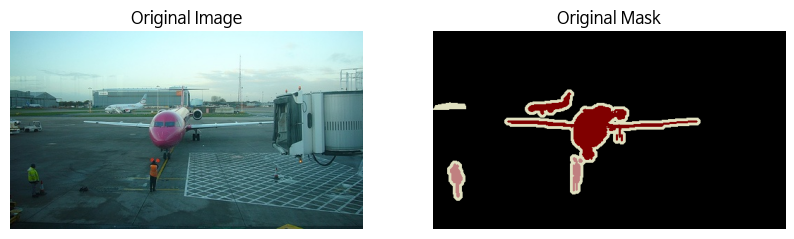

In [12]:
# 원본 데이터를 시각화해봅니다.
raw_image, raw_mask = voc_dataset[0]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(raw_image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(raw_mask)
plt.title("Original Mask")
plt.axis("off")
plt.show()

In [13]:
mask_np = np.array(raw_mask)
print('마스크의 고유 값:', np.unique(mask_np))

mask_np_fixed = np.where(mask_np == 255, 0, mask_np)
print('수정된 마스크의 고유 값:', np.unique(mask_np_fixed))

마스크의 고유 값: [  0   1  15 255]
수정된 마스크의 고유 값: [ 0  1 15]


In [14]:
import os
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from PIL import Image

# VOC 데이터셋의 기본 경로 설정 (VOCdevkit/VOC2012)
voc_root = os.path.join(voc_dataset.root, "VOCdevkit","VOC2012")

# Annotations 폴더 경로 지정
annotation_dir = os.path.join(voc_root, "Annotations")

# Annotations 폴더 내의 모든 XML 파일 목록 확인
annotation_files = [f for f in os.listdir(annotation_dir) if f.endswith('.xml')]
print("전체 annotation 파일 수:", len(annotation_files))

# 예시로 첫 번째 annotation 파일 선택
sample_annotation_file = annotation_files[0]
sample_annotation_path = os.path.join(annotation_dir, sample_annotation_file)
print("예시 annotation 파일 경로:", sample_annotation_path)
print(os.path.splitext(os.path.basename(sample_annotation_path))[0])



전체 annotation 파일 수: 17125
예시 annotation 파일 경로: /root/.cache/kagglehub/datasets/likhon148/visual-object-classes-voc-12/versions/1/VOCdevkit/VOC2012/Annotations/2010_006751.xml
2010_006751


In [15]:
########################################
# Step 1: XML 파싱을 통해 annotation 데이터 로드하기
########################################
# xml.etree.ElementTree를 이용해 XML 파일을 파싱합니다.
tree = ET.parse(sample_annotation_path)
root_xml = tree.getroot()

# 파일명 출력 (이미지 파일명)
filename = root_xml.find("filename").text
print("이미지 파일명:", filename)

# 이미지 크기 정보 확인
size_elem = root_xml.find("size")
width = size_elem.find("width").text
height = size_elem.find("height").text
depth = size_elem.find("depth").text
print("이미지 크기 - Width:", width, ", Height:", height, ", Depth:", depth)
#print('이미지 실제 크기', voc_dataset[0][0].size)

print(os.path.splitext(os.path.basename(voc_dataset.images[0]))[0])


이미지 파일명: 2010_006751.jpg
이미지 크기 - Width: 480 , Height: 360 , Depth: 3
2007_000032


In [16]:
########################################
# Step 2: 객체 정보(Annotation) 확인하기
########################################
print("\n이미지 내 객체 정보:")
for obj in root_xml.findall("object"):
    # 객체 이름(클래스) 가져오기
    obj_name = obj.find("name").text

    # 객체의 bounding box 정보 가져오기
    bndbox = obj.find("bndbox")
    xmin = int(bndbox.find("xmin").text)
    ymin = int(bndbox.find("ymin").text)
    xmax = int(bndbox.find("xmax").text)
    ymax = int(bndbox.find("ymax").text)

    print(f"- 객체: {obj_name}, Bounding Box: ({xmin}, {ymin}, {xmax}, {ymax})")



이미지 내 객체 정보:
- 객체: person, Bounding Box: (227, 76, 267, 179)


Text(0.5, 1.0, 'Annotation example')

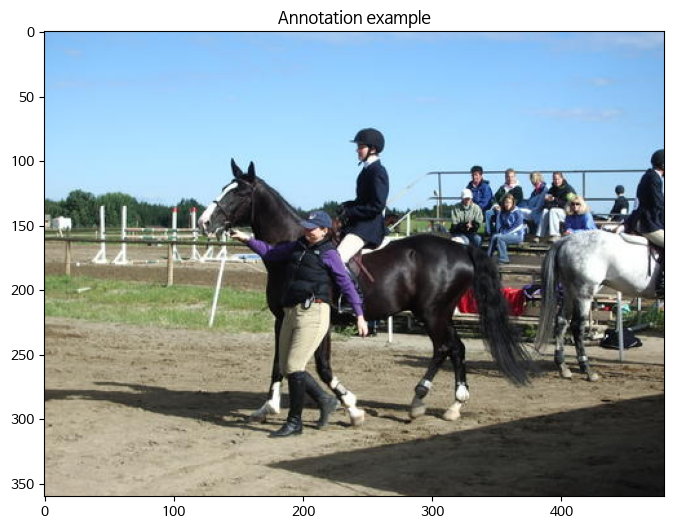

In [17]:
########################################
# Step 3: 이미지와 bounding box 시각화하기
########################################
# 이미지 파일 경로: VOCdevkit/VOC2012/JPEGImages 폴더 내에 있습니다.
image_path = os.path.join(voc_root, "JPEGImages", filename)
image = Image.open(image_path)

# 시각화를 위해 matplotlib의 기능을 사용합니다.
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.title(f"Annotation example")

In [18]:
# Pascal VOC 데이터셋의 segmentation 결과를 시각화하기 위해,
# 각 클래스에 대해 고유한 색상 코드를 지정합니다.
# 일반적으로 background는 0번, 객체 클래스는 1~20번으로 정의되며,
# 각 객체 클래스에 대해 클래스 번호에 따라 서로다른 RGB 색상 코드를 생성합니다.
# [i * 10 % 256, i * 20 % 256, i * 30 % 256]
# % 256 연산을 통해 각 색상 채널의 값이 0에서 255 사이로 유지됩니다
categories = {
    str(i): {
        "class": f"class_{i}",
        "color": [i * 10 % 256, i * 20 % 256, i * 30 % 256]
    } for i in range(1, 22)
}
categories

{'1': {'class': 'class_1', 'color': [10, 20, 30]},
 '2': {'class': 'class_2', 'color': [20, 40, 60]},
 '3': {'class': 'class_3', 'color': [30, 60, 90]},
 '4': {'class': 'class_4', 'color': [40, 80, 120]},
 '5': {'class': 'class_5', 'color': [50, 100, 150]},
 '6': {'class': 'class_6', 'color': [60, 120, 180]},
 '7': {'class': 'class_7', 'color': [70, 140, 210]},
 '8': {'class': 'class_8', 'color': [80, 160, 240]},
 '9': {'class': 'class_9', 'color': [90, 180, 14]},
 '10': {'class': 'class_10', 'color': [100, 200, 44]},
 '11': {'class': 'class_11', 'color': [110, 220, 74]},
 '12': {'class': 'class_12', 'color': [120, 240, 104]},
 '13': {'class': 'class_13', 'color': [130, 4, 134]},
 '14': {'class': 'class_14', 'color': [140, 24, 164]},
 '15': {'class': 'class_15', 'color': [150, 44, 194]},
 '16': {'class': 'class_16', 'color': [160, 64, 224]},
 '17': {'class': 'class_17', 'color': [170, 84, 254]},
 '18': {'class': 'class_18', 'color': [180, 104, 28]},
 '19': {'class': 'class_19', 'color'

In [19]:

import os
import json
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import matplotlib.pyplot as plt


# VOC 2012 클래스 이름 리스트
VOC_CLASSES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat',
    'bottle', 'bus', 'car', 'cat', 'chair',
    'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]

VOC_CLASSES_KO = [
    '배경', '비행기', '자전거', '새', '보트',
    '병', '버스', '자동차', '고양이', '의자',
    '소', '식탁', '개', '말', '오토바이',
    '사람', '화분', '양', '소파', '기차', 'TV모니터'
]

VOC_COLORMAP = [
    (0, 0, 0),         # 0: background
    (128, 0, 0),       # 1: aeroplane
    (0, 128, 0),       # 2: bicycle
    (128, 128, 0),     # 3: bird
    (0, 0, 128),       # 4: boat
    (128, 0, 128),     # 5: bottle
    (0, 128, 128),     # 6: bus
    (128, 128, 128),   # 7: car
    (64, 0, 0),        # 8: cat
    (192, 0, 0),       # 9: chair
    (64, 128, 0),      # 10: cow
    (192, 128, 0),     # 11: diningtable
    (64, 0, 128),      # 12: dog
    (192, 0, 128),     # 13: horse
    (64, 128, 128),    # 14: motorbike
    (192, 128, 128),   # 15: person
    (0, 64, 0),        # 16: pottedplant
    (128, 64, 0),      # 17: sheep
    (0, 192, 0),       # 18: sofa
    (128, 192, 0),     # 19: train
    (0, 64, 128),      # 20: tvmonitor
    # ... (추가 색상)
    (224, 224, 192),   # 255: ignore (테두리 등)
]

def rgb_to_class_id(rgb):
    for idx, color in enumerate(VOC_COLORMAP):
        if color == rgb:
            return idx
    return None

def class_id_to_rgb(class_id):
    """
    VOC2012 공식 color map 기준으로 클래스 ID에 해당하는 RGB 컬러 반환
    """
    if 0 <= class_id < len(VOC_COLORMAP):
        return VOC_COLORMAP[class_id]
    return None


# print(rgb_to_class_id((192, 0, 0)))     # 9: chair
# print(rgb_to_class_id((64, 0, 128)))    # 12: dog
# print(rgb_to_class_id((224, 224, 192))) # 255: ignore

# # 클래스 번호로 이름 가져오기
# class_id = 15  # 예시: person
# print(VOC_CLASSES[class_id])  # 'person'

###############################################
# Step 1: VOCSegmentation 데이터셋 로드 및 클래스 정보 설정하기
###############################################
class SegmentationDataset(Dataset):
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        """
        VOCSegmentation 데이터셋을 로드하고, 이미지와 pixel-level segmentation mask를 반환하는 Dataset 클래스입니다.

        Args:
            root (str): 데이터셋이 저장될 루트 경로
            train (bool): True이면 training 데이터를, False이면 validation 데이터를 사용
            transform: 입력 이미지에 적용할 변환(예: 크기 조정, tensor 변환 등)
            target_transform: segmentation mask에 적용할 변환(보통 크기 조정 등, 클래스 값 보존을 위해 nearest interpolation 사용)
            download (bool): 데이터가 없으면 자동으로 다운로드할지 여부
        """
        # train이면 'train', 아니면 'val' 이미지를 선택합니다.
        image_set = 'train' if train else 'val'

        # torchvision의 VOCSegmentation 클래스를 사용하여 VOC 데이터셋을 불러옵니다.
        # self.voc = datasets.VOCSegmentation(
        #     root=root,
        #     year='2012',
        #     image_set=image_set,
        #     download=download
        # )

        self.voc = datasets.VOCSegmentation(
            root=root,
            year='2012',
            image_set=image_set,
            # transform=transform,
            # target_transform=target_transform,
            download=download
        )

        # 일관된 시각화를 위해 클래스 별로 색상코드 지정
        # self.categories = {str(i): {"class": f"class_{i}",
        #                             "color": [i * 10 % 256, i * 20 % 256, i * 30 % 256]}
        #                    for i in range(1, 22)}

        self.categories = {str(i): {"class": f"class_{i}",
                                    "color": class_id_to_rgb(i)}
                           for i in range(1, 22)}

        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        """
        주어진 index에 해당하는 이미지와 segmentation mask를 반환합니다.
        """
        # VOCSegmentation 객체로부터 image와 mask를 불러옵니다.
        image, mask = self.voc[index]

        # mask는 PIL.Image 형태로 로드되므로 numpy 배열로 변환하여 각 픽셀 값을 확인할 수 있습니다.
        mask = np.array(mask)

        # VOC 마스크에서는 255가 'ignore label'로 사용됩니다.
        # 모델 학습 시 ignore label은 보통 처리하지 않으므로, 여기서는 0 (배경)으로 대체합니다.
        mask = np.where(mask == 255, 0, mask)

        # numpy 배열을 파이토치의 LongTensor로 변환합니다.
        # unsqueeze(0)은 마스크에 채널 차원을 추가하여 (1, H, W) 형태로 만듭니다.
        target = torch.LongTensor(mask).unsqueeze(0)

        # 입력 이미지에 설정된 transform(예: 크기 조정, tensor 변환 등)을 적용합니다.
        if self.transform is not None:
            image = self.transform(image)
        # 마스크에도 target_transform이 있다면 적용합니다.
        if self.target_transform is not None:
            target = self.target_transform(target)
        return image, target

    def __len__(self):
        """
        데이터셋에 포함된 샘플의 총 개수를 반환합니다.
        """
        return len(self.voc)


###############################################
# Step 2: 이미지와 마스크에 적용할 전처리(Transform) 정의하기
###############################################
# 이미지 변환:
# 1. PIL 이미지를 tensor로 변환
# 2. tensor의 데이터 타입을 float로 변경
# 3. 이미지 크기를 (224, 224)로 조정
transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Resize((224, 224))
])

# 마스크 변환:
# 마스크는 정수값(클래스 id)을 가지므로, 크기 조정 시 nearest interpolation을 사용하여 값이 보존되도록 합니다.
target_transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.NEAREST)
])



In [20]:
###############################################
# Step 3: 데이터셋과 DataLoader 생성하기
###############################################
# 데이터셋 경로 (VOC 데이터셋의 루트 폴더)
root = voc_dataset.root

# train 데이터셋 생성 (필요시 download=True 옵션 사용)
train_dataset = SegmentationDataset(root, train=True, transform=transform, target_transform=target_transform, download=False)
# test 또는 validation 데이터셋 생성
test_dataset = SegmentationDataset(root, train=False, transform=transform, target_transform=target_transform, download=False)

# DataLoader 생성: 데이터를 배치 단위로 불러와 학습에 사용할 수 있도록 합니다.
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False, drop_last=True)


In [21]:
# 클래스 별 RGB값 딕셔너리에서 꺼내오기 (default 없음)
train_dataset.categories.get(str(1))

{'class': 'class_1', 'color': (128, 0, 0)}

In [22]:
train_dataset.categories.get(str(100)) # return None

In [23]:
# 클래스 별 RGB값 딕셔너리에서 꺼내오기 (키가 없을 때 default 설정)
train_dataset.categories.get(str(100), {"color": [0, 0, 0]})

{'color': [0, 0, 0]}

In [33]:
###############################################
# Step 4: 시각화 함수 정의하기
###############################################
def draw_mask(images, masks, outputs=None, plot_size=4):
    """
    이미지와 segmentation mask를 시각화 + 각 객체의 bounding box(테두리)도 표시
    """
    import matplotlib.patches as patches

    def color_mask(image, target):
        m = target.squeeze().numpy().astype(np.uint8)
        cm = np.zeros_like(image, dtype=np.uint8)
        for i in range(1, 21):
            cm[m == i] = train_dataset.categories.get(str(i), {"color": [0, 0, 0]})["color"]

        classes = []
        for idx in np.unique(m):
            class_txt = f'{idx}({VOC_CLASSES[idx]}/{VOC_CLASSES_KO[idx]})'
            classes.append(class_txt)
        return cm, classes, m

    col = 3 if outputs is not None else 2
    figsize = 8 if outputs is not None else 12
    fig, ax = plt.subplots(plot_size, col, figsize=(10, figsize), constrained_layout=True)

    for batch in range(plot_size):
        im = images[batch].numpy().transpose(1, 2, 0)
        ax[batch][0].imshow(im)
        ax[batch][0].set_title(f"input image")
        ax[batch][0].axis("off")

        # 실제 마스크
        cm, classes, m = color_mask(im, masks[batch])
        ax[batch][1].imshow(cm)
        ax[batch][1].set_title("real mask\n" + "\n".join(classes))
        ax[batch][1].axis("off")

        # 각 클래스별로 bounding box(테두리) 그리기
        for idx in np.unique(m):
            if idx == 0:
                continue  # 배경은 제외
            ys, xs = np.where(m == idx)
            if len(xs) == 0 or len(ys) == 0:
                continue
            x_min, x_max = xs.min(), xs.max()
            y_min, y_max = ys.min(), ys.max()
            rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                    linewidth=2, edgecolor='yellow', facecolor='none')
            ax[batch][1].add_patch(rect)
            ax[batch][1].text(x_min, y_min, f'{VOC_CLASSES[idx]}({VOC_CLASSES_KO[idx]})', color='yellow', fontsize=8, backgroundcolor='black')

        # 예측 결과도 있으면 동일하게 처리
        if outputs is not None:
            cm, classes, m = color_mask(im, outputs[batch])
            ax[batch][2].imshow(cm)
            ax[batch][2].set_title("pred mask\n" + "\n".join(classes))
            ax[batch][2].axis("off")
            for idx in np.unique(m):
                if idx == 0:
                    continue
                ys, xs = np.where(m == idx)
                if len(xs) == 0 or len(ys) == 0:
                    continue
                x_min, x_max = xs.min(), xs.max()
                y_min, y_max = ys.min(), ys.max()
                rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                        linewidth=2, edgecolor='red', facecolor='none')
                ax[batch][2].add_patch(rect)
                ax[batch][2].text(x_min, y_min, f'{VOC_CLASSES[idx]}({VOC_CLASSES_KO[idx]})', color='red', fontsize=8, backgroundcolor='black')



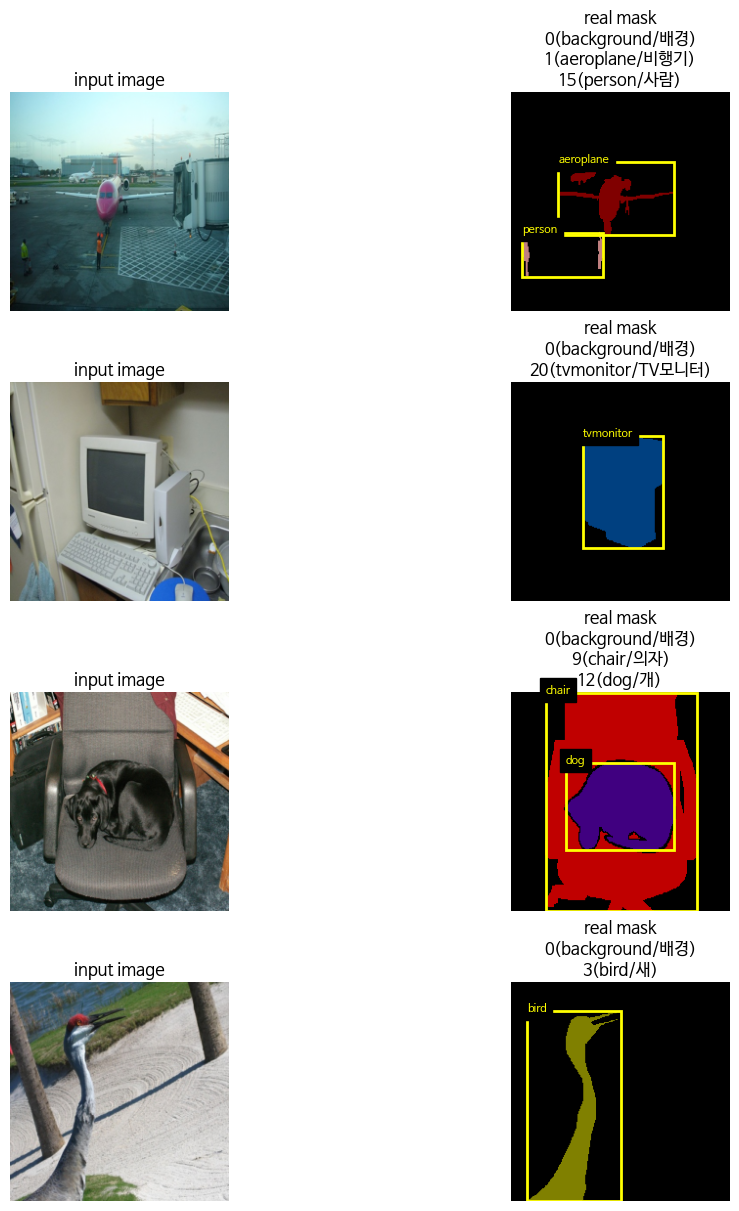

In [25]:

###############################################
# Step 5: DataLoader에서 한 배치 가져와 시각화하기
###############################################
# train DataLoader에서 한 배치를 가져옵니다.
images, masks = next(iter(train_dataloader))
# 첫 배치의 결과를 시각화하여 데이터 로드와 전처리 과정이 올바르게 작동하는지 확인합니다.
draw_mask(images, masks, plot_size=4)


In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from tqdm import tqdm
import numpy as np

# FCN-8s 모델 정의 (VGG16 백본 사용)
class FCN8s(nn.Module):
    def __init__(self, num_classes=21):
        super(FCN8s, self).__init__()
        vgg16 = models.vgg16(pretrained=True)
        features = list(vgg16.features.children())
        # VGG16에서 중간 feature map 추출
        # pool3: features[0:17] (약 1/8 해상도)
        # pool4: features[17:24] (약 1/16 해상도)
        # pool5: features[24:]   (약 1/32 해상도)
        self.pool3 = nn.Sequential(*features[:17])
        self.pool4 = nn.Sequential(*features[17:24])
        self.pool5 = nn.Sequential(*features[24:])

        # 1x1 convolution으로 각 feature map의 채널 수를 num_classes로 축소
        self.score_pool3 = nn.Conv2d(256, num_classes, kernel_size=1)
        self.score_pool4 = nn.Conv2d(512, num_classes, kernel_size=1)
        self.score_fr    = nn.Conv2d(512, num_classes, kernel_size=1)

        # Transposed convolution (upsampling) layers
        # score_fr (1/32 해상도) -> upsample x2 -> 1/16 해상도
        self.upscore2 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1, bias=False)
        # fuse_pool4 (1/16 해상도) -> upsample x2 -> 1/8 해상도
        self.upscore_pool4 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1, bias=False)
        # fuse_pool3 (1/8 해상도) -> upsample x8 -> 원본 해상도
        self.upscore8 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=16, stride=8, padding=4, bias=False)

    def forward(self, x):
        input_size = x.size()  # [B, C, H, W]
        pool3 = self.pool3(x)  # 1/8 해상도, 채널: 256
        pool4 = self.pool4(pool3)  # 1/16 해상도, 채널: 512
        pool5 = self.pool5(pool4)  # 1/32 해상도, 채널: 512

        score_fr = self.score_fr(pool5)  # [B, num_classes, H/32, W/32]
        upscore2 = self.upscore2(score_fr)  # upsample x2 -> [B, num_classes, H/16, W/16]

        score_pool4 = self.score_pool4(pool4)  # [B, num_classes, H/16, W/16]
        fuse_pool4 = upscore2 + score_pool4  # skip connection

        upscore_pool4 = self.upscore_pool4(fuse_pool4)  # upsample x2 -> [B, num_classes, H/8, W/8]

        score_pool3 = self.score_pool3(pool3)  # [B, num_classes, H/8, W/8]
        fuse_pool3 = upscore_pool4 + score_pool3  # skip connection

        upscore8 = self.upscore8(fuse_pool3)  # upsample x8 -> [B, num_classes, H, W]

        # 입력 크기와 정확히 맞지 않을 경우, crop하여 맞춥니다.
        out = upscore8[:, :, :input_size[2], :input_size[3]]
        return out


In [27]:

# 하이퍼파라미터 및 디바이스 설정
num_classes = 21
device = "cuda" if torch.cuda.is_available() else "cpu"
model = FCN8s(num_classes=num_classes).to(device)

# 옵티마이저와 손실 함수 설정
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
criterion = nn.CrossEntropyLoss()

# 학습 loop (tqdm으로 진행 상황 표시)
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, targets in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = images.to(device)
        targets = targets.to(device)  # targets shape: [B, H, W]

        # 타겟의 차원 확인 후 squeeze
        if targets.dim() == 4 and targets.size(1) == 1:
            targets = targets.squeeze(1)


        optimizer.zero_grad()
        outputs = model(images)  # outputs shape: [B, num_classes, H, W]
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    avg_loss = running_loss / len(train_dataloader)
    print(f"Epoch {epoch+1} Loss: {avg_loss:.4f}")


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:02<00:00, 218MB/s]
Epoch 1/20: 100%|██████████| 366/366 [00:20<00:00, 17.96it/s]


Epoch 1 Loss: 1.5826


Epoch 2/20: 100%|██████████| 366/366 [00:18<00:00, 19.30it/s]


Epoch 2 Loss: 1.1834


Epoch 3/20: 100%|██████████| 366/366 [00:18<00:00, 19.37it/s]


Epoch 3 Loss: 1.1416


Epoch 4/20: 100%|██████████| 366/366 [00:19<00:00, 19.24it/s]


Epoch 4 Loss: 1.0847


Epoch 5/20: 100%|██████████| 366/366 [00:18<00:00, 19.26it/s]


Epoch 5 Loss: 1.0344


Epoch 6/20: 100%|██████████| 366/366 [00:18<00:00, 19.32it/s]


Epoch 6 Loss: 0.9881


Epoch 7/20: 100%|██████████| 366/366 [00:19<00:00, 19.09it/s]


Epoch 7 Loss: 0.9495


Epoch 8/20: 100%|██████████| 366/366 [00:18<00:00, 19.31it/s]


Epoch 8 Loss: 0.9183


Epoch 9/20: 100%|██████████| 366/366 [00:18<00:00, 19.35it/s]


Epoch 9 Loss: 0.8899


Epoch 10/20: 100%|██████████| 366/366 [00:18<00:00, 19.33it/s]


Epoch 10 Loss: 0.8614


Epoch 11/20: 100%|██████████| 366/366 [00:18<00:00, 19.43it/s]


Epoch 11 Loss: 0.8337


Epoch 12/20: 100%|██████████| 366/366 [00:18<00:00, 19.34it/s]


Epoch 12 Loss: 0.8070


Epoch 13/20: 100%|██████████| 366/366 [00:19<00:00, 19.23it/s]


Epoch 13 Loss: 0.7814


Epoch 14/20: 100%|██████████| 366/366 [00:19<00:00, 19.23it/s]


Epoch 14 Loss: 0.7562


Epoch 15/20: 100%|██████████| 366/366 [00:18<00:00, 19.32it/s]


Epoch 15 Loss: 0.7313


Epoch 16/20: 100%|██████████| 366/366 [00:19<00:00, 19.22it/s]


Epoch 16 Loss: 0.7073


Epoch 17/20: 100%|██████████| 366/366 [00:19<00:00, 19.17it/s]


Epoch 17 Loss: 0.6844


Epoch 18/20: 100%|██████████| 366/366 [00:19<00:00, 19.17it/s]


Epoch 18 Loss: 0.6608


Epoch 19/20: 100%|██████████| 366/366 [00:19<00:00, 18.97it/s]


Epoch 19 Loss: 0.6379


Epoch 20/20: 100%|██████████| 366/366 [00:19<00:00, 19.17it/s]

Epoch 20 Loss: 0.6141


In [28]:
torch.save(model.state_dict(), 'fcn-8.pth')

In [29]:
model_loaded = FCN8s(num_classes=num_classes).to(device)
model_loaded.load_state_dict(torch.load('fcn-8.pth'))

<All keys matched successfully>

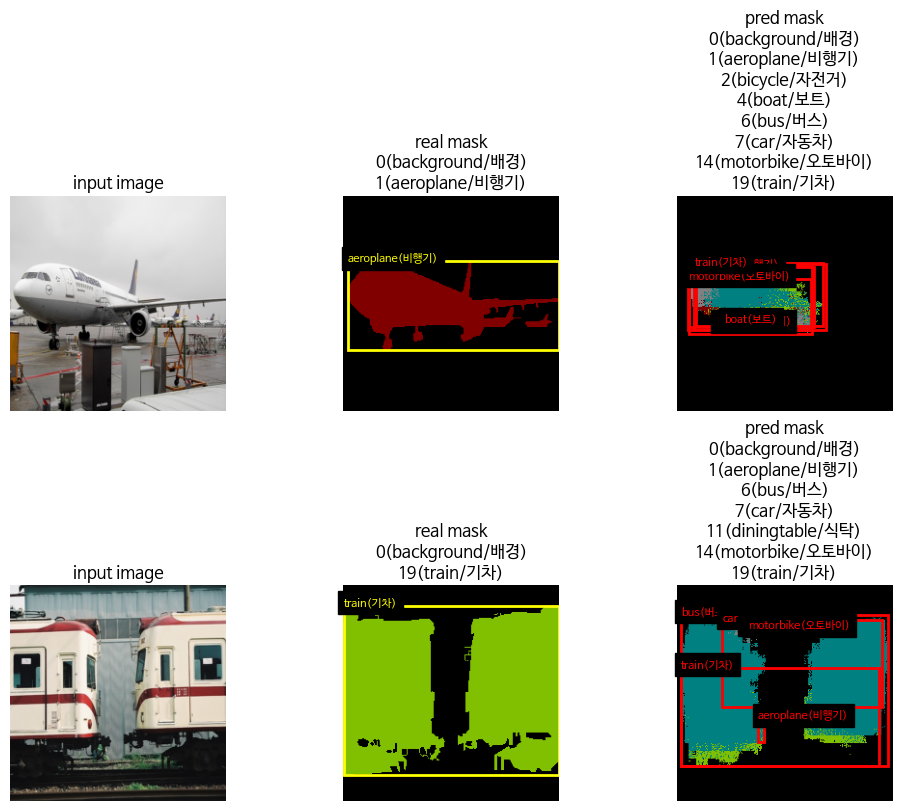

In [34]:
# 평가 예시 (tqdm을 사용)
with torch.no_grad():
    model.eval()
    images, masks = next(iter(test_dataloader))
    outputs = model(images.to(device))
    outputs = outputs.argmax(dim=1).to("cpu")
    draw_mask(images, masks, outputs, 2)

In [36]:
# mIoU 계산 예시
from collections import defaultdict

def calculate_iou(targets, outputs, ious, class_count, num_classes=21):
    for i in range(num_classes):
        intersection = np.float32(np.sum((outputs == targets) * (targets == i)))
        union = np.sum(targets == i) + np.sum(outputs == i) - intersection
        if union > 0:
            ious[i] += intersection / union
            class_count[i] += 1
    return ious, class_count

ious = np.zeros(num_classes)
class_count = defaultdict(int)
with torch.no_grad():
    model.eval()
    for images, targets in tqdm(test_dataloader, desc="Evaluating"):
        images = images.to(device)
        outputs = model(images).detach().to("cpu").numpy()  # [B, num_classes, H, W]
        targets = targets.detach().to("cpu").numpy()          # [B, H, W]
        outputs = outputs.argmax(axis=1)
        ious, class_count = calculate_iou(targets, outputs, ious, class_count, num_classes)

miou = 0.0
for idx in range(1, num_classes):
    miou += ious[idx] / class_count[idx]
miou /= (num_classes - 1)
print(f"mIoU 계산 결과 : {miou}")


Evaluating: 100%|██████████| 724/724 [00:26<00:00, 27.33it/s]

mIoU 계산 결과 : 0.04391538211265812


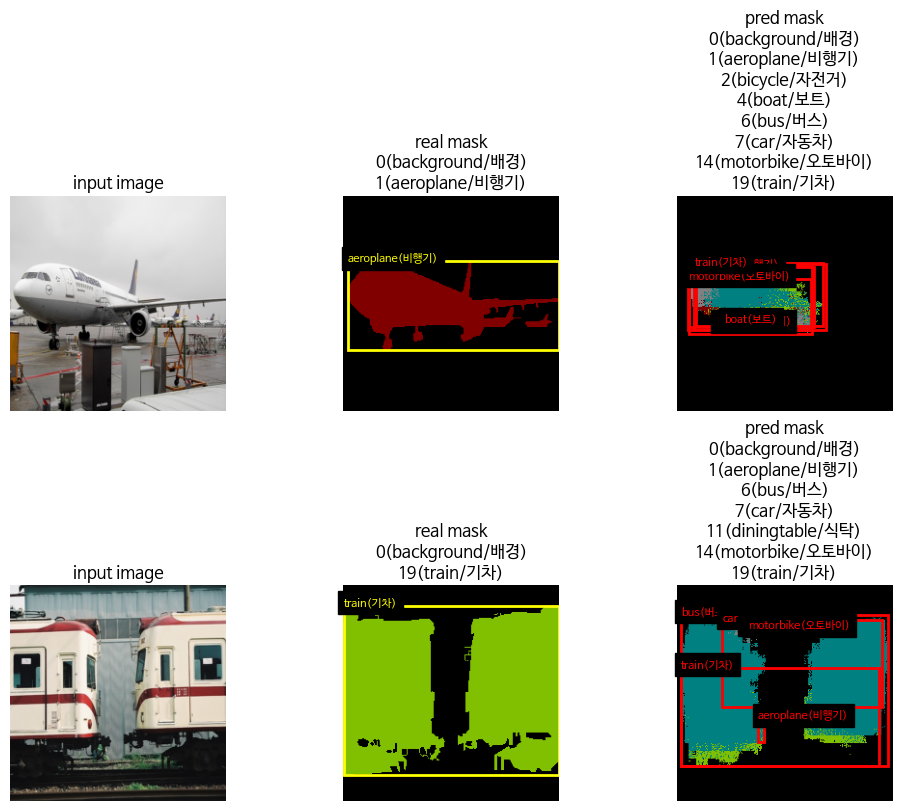

In [35]:
# 평가 예시 (tqdm을 사용)
model_loaded
with torch.no_grad():
    model_loaded.eval()
    images, masks = next(iter(test_dataloader))
    outputs = model_loaded(images.to(device))
    outputs = outputs.argmax(dim=1).to("cpu")
    draw_mask(images, masks, outputs, 2)